In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
import random 
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import label_binarize

In [2]:
def myLogisticRegression(X, Y, test_size=0.33, random_state=None):

    xTrain, xTest, yTrain, yTest = train_test_split(X, Y, test_size=test_size, random_state=random_state)

    clf = linear_model.LogisticRegression(penalty='l2', solver='lbfgs', max_iter=1000)

    clf.fit(xTrain, yTrain)

    yPred = clf.predict(xTest)
    
    # score
    scoreTrain = clf.score(xTrain, yTrain)
    scoreTest = clf.score(xTest, yTest)
    
    # 計算 Predict confidence scores for samples.
    yScore = clf.decision_function(xTest)

    # evaluate ROC and AUC
    fpr, tpr, _ = metrics.roc_curve(yTest, yScore)
    auc = metrics.auc(fpr, tpr)

    print("Score of training set = {:.3f}".format(scoreTrain))
    print("Score of testing set = {:.3f} ".format(scoreTest))
    print("AUC = {:.3f} ".format(auc))
    print("Report: ")
    print(metrics.classification_report(yTest, yPred))

    return scoreTrain, scoreTest, fpr, tpr, auc

# Iris

In [3]:
# reading data from sklearn database
from sklearn import datasets

dataIris = datasets.load_iris()

# setting x
df = pd.DataFrame(dataIris.data, columns=dataIris.feature_names)

# setting \hat_y
df["target"] = dataIris.target

df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


In [4]:
xData = df.drop(["target"], axis=1)
yData = df["target"]

xTrain, xTest, yTrain, yTest = train_test_split(xData, yData, test_size=0.33, random_state=0)


# penalty: {‘l1’, ‘l2’, ‘elasticnet’, ‘none’}, default=’l2’ choice regularization
# solver: {‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’}, default=’lbfgs’

clf = linear_model.LogisticRegression(penalty='l2', solver='lbfgs')

clf.fit(xTrain, yTrain)

yPred = clf.predict(xTest)

scoreTrain = clf.score(xTrain, yTrain)

scoreTest = clf.score(xTest, yTest) # = metrics.accuracy_score(y_test, y_pred)

confMatrix = metrics.confusion_matrix(yTest, yPred)

#print("coeff =", clf.coef_)
#print("bias =", clf.intercept_)
print("score of training set = {:.3f}".format(scoreTrain))
print("score of testing set = {:.3f} ".format(scoreTest))
print("Report: ")
print(metrics.classification_report(yTest, yPred))

score of training set = 0.980
score of testing set = 0.980 
Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       1.00      0.95      0.97        19
           2       0.94      1.00      0.97        15

    accuracy                           0.98        50
   macro avg       0.98      0.98      0.98        50
weighted avg       0.98      0.98      0.98        50



## 重建Neural Network，驗證公式

Iris有三種類別，因此使用softmax = $\large \frac{e^{z_i}}{\sum_j e^{z_j}}$ 得到probability

Softmax會使總機率=1

也可以透過Sigmoid = $\large \frac{1}{1+e^{-z}}$得到在該class的機率，選擇最大的作為預測值，但全部class的機率相加會>1

---

form:

z of class-T: $\large z^{cT}_i = w^{cT}*x^{cT}_i + b^{cT}$ T = 0, 1, 2 in this case

$w^{cT}$ can get by **clf.coef_**

$b^{cT}$ can get by **clf.intercept_**

<span style="color:blue">**Note**</span>: 請注意要先做 (w\*x).sum()再才加b，否則變成 (w\*x+b).sum() 會多出3個b (in iris case have 4-feature)

In [5]:
x = xTest.iloc[0]
x

sepal length (cm)    5.8
sepal width (cm)     2.8
petal length (cm)    5.1
petal width (cm)     2.4
Name: 114, dtype: float64

In [6]:
w = clf.coef_
w

array([[-0.41717186,  0.76651295, -2.23901382, -0.96596136],
       [ 0.54340788, -0.3715756 , -0.16956574, -0.71588956],
       [-0.12623602, -0.39493735,  2.40857955,  1.68185092]])

In [7]:
b = clf.intercept_
b

array([  9.11624777,   1.58473723, -10.700985  ])

In [8]:
# construct NN 

ez = []
probSigmoid = []
for idx in range(3):
    #print("class",idx)
    # z = w[idx] * x + b[idx]
    # z = z.sum() # Error!!!
    z = (w[idx] * x).sum() + b[idx]
    #print(w[idx])
    #print(x)
    #print(b[idx])
    #print(z)
    ez.append(np.exp(z))
    
    # sigmoid func
    prob = 1 / (1 + np.exp(-z))
    probSigmoid.append(prob)
    
print("Results:")
probSoftmax = ez/np.sum(ez)

for idx in range(3):
    print("class-%d" %(idx))
    print("Sigmoid = %.3f, Softmax = %.3f" %(probSigmoid[idx], probSoftmax[idx]))


Results:
class-0
Sigmoid = 0.007, Softmax = 0.000
class-1
Sigmoid = 0.753, Softmax = 0.065
class-2
Sigmoid = 0.978, Softmax = 0.935


In [9]:
# check ans with sklearn proba
# np.log(clf.predict_proba(xTest))  == clf.predict_log_proba(xTest)
clf.predict_proba(xTest)[0]

array([1.59597487e-04, 6.48749251e-02, 9.34965477e-01])

## Confusion matrix 混淆矩陣 Note

|             | Actual Yes          | Actual No           |
|-------------|---------------------|---------------------|
| Predict Yes | TP (True Positive)  | FP (False Positive) |
| Predict No  | FN (Talse Negative) | TN (False Negative) |

**評估指標:**

**常用**

**Accuracy** = $\large \frac{TP \: + \: TN}{Total}$


其他

Recall = $\large \frac{TP}{TP \: + \: FN}$

Precision = $\large \frac{TP}{TP \: + \: FP}$

Specificity = $\large \frac{TN}{TN \: + \: FP}$

F1-Score = $\large \frac{2}{\frac{1}{Recall} \: + \: \frac{1}{Precision}}$


<AxesSubplot:>

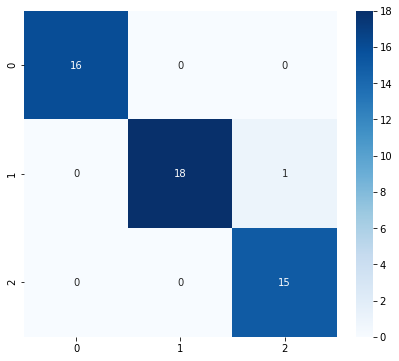

In [10]:
plt.figure(figsize=(7,6))
sns.heatmap(confMatrix, annot=True, cmap="Blues")

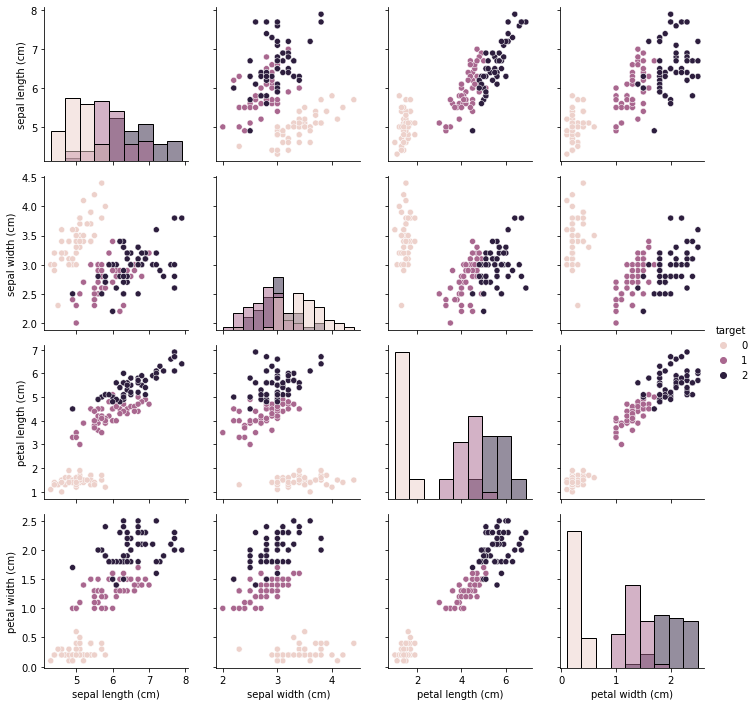

In [11]:
g = sns.PairGrid(df, hue="target")
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()

## ROC curve and AUC

**ROC curve**: Receiver Operator Characteristic Curve

例如wiki/Receiver_operating_characteristic，人體的血液蛋白濃度是呈常態分布的連續變數，病人的分布是紅色，平均值為A g/dL，健康人的分布是藍色，平均值是C g/dL。健康檢查會測量血液樣本中的某種蛋白質濃度，達到某個值（閾值，threshold）以上診斷為有疾病徵兆。研究者可以調整閾值的高低（將左上圖的B垂直線往左或右移動），便會得出不同的偽陽性率與真陽性率，總之即得出不同的預測準確率。


Axis-X: FPR(偽陽性率) = $\large \frac{FP}{FP \: + \: TN}$

Axis-Y: TPR(真陽性率) = $\large \frac{TP}{TP \: + \: FN}$

**AUC**: Area Under Curve

表在ROC曲線下的面積，能表示分類器預測能力的一項常用的統計值 AUC=1 is best prediction

In [12]:
# for multi-class, need to one-hot encode => convert to one-vs-All problem
# ref: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
yTestLB = label_binarize(yTest, classes=[0, 1, 2])
#print(yTestLB.shape)

# 計算 Predict confidence scores for samples.
yScore = clf.decision_function(xTest)
#print(yScore)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
auc = dict()
for idx in range(3):
    fpr[idx], tpr[idx], _ = metrics.roc_curve(yTestLB[:, idx], yScore[:, idx])
    auc[idx] = metrics.auc(fpr[idx], tpr[idx])
    print("AUC of class-%d = %.3f" %(idx, auc[idx]))

AUC of class-0 = 1.000
AUC of class-1 = 0.433
AUC of class-2 = 0.994


In [13]:
# micro = 將全部預測正確的結果統計FPR&TPR 在計算AUC
# macro = AUC個別計算後，再取AUC的平均

# Compute micro-average ROC curve and ROC area
# ravel() == flatten(), 差異在 revel is mutable, flatten is immutable. flatten is slower than ravel,
# becuase flatten will copy and create the element
fpr["micro"], tpr["micro"], _ = metrics.roc_curve(yTestLB.ravel(), yScore.ravel())
auc["micro"] = metrics.auc(fpr["micro"], tpr["micro"])

print("micro AUC = %.3f" %(auc["micro"]))

# First aggregate all false positive rates
# 因為3個特徵的x-axis的取樣點有差異，先綁在一起，在去掉重複的點，成為新的x-axis for marco-average
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(3)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(3):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i]) # interp 用內插法計算新的點 後續取三條線的平均

# Finally average it and compute AUC
mean_tpr /= 3

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
auc["macro"] = metrics.auc(fpr["macro"], tpr["macro"])

print("macro AUC = %.3f" %(auc["macro"]))

micro AUC = 0.918
macro AUC = 0.822


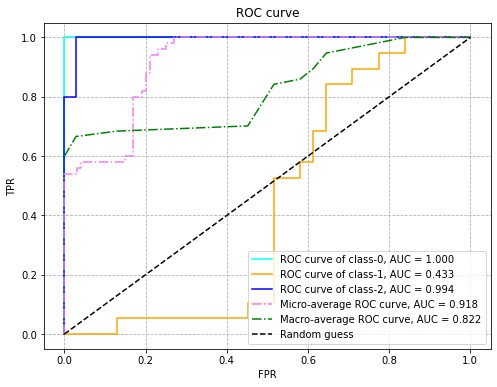

In [14]:
# plot ROC

plt.figure(figsize=(8, 6))
cmap = ["aqua", "orange", "blue"]
for idx in range(3):
    plt.plot(fpr[idx], tpr[idx], linestyle="solid", color=cmap[idx], label="ROC curve of class-%d, AUC = %.3f" %(idx, auc[idx]))

plt.plot(fpr["micro"], tpr["micro"], linestyle="dashdot", color="violet", label="Micro-average ROC curve, AUC = %.3f" %(auc["micro"]))    
plt.plot(fpr["macro"], tpr["macro"], linestyle="dashdot", color="green", label="Macro-average ROC curve, AUC = %.3f" %(auc["macro"]))    

plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100), linestyle="dashed", color="black", label="Random guess")

plt.grid(linestyle='--')
plt.title("ROC curve")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.show()

# 員工離職預測

In [15]:
rawData = pd.read_csv("../../data/HR_comma_sep.csv")
rawData.info()
rawData

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   sales                  14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low
...,...,...,...,...,...,...,...,...,...,...
14994,0.40,0.57,2,151,3,0,1,0,support,low
14995,0.37,0.48,2,160,3,0,1,0,support,low
14996,0.37,0.53,2,143,3,0,1,0,support,low
14997,0.11,0.96,6,280,4,0,1,0,support,low


**Feature**

satisfaction_level     : 對公司的滿意度

last_evaluation        : 績效

number_project         : 參與的專案數目

average_montly_hours   : 平均月工時

time_spend_company     : 工作年資 

Work_accident          : 工作是否發生事故 0=false, 1=true

left                   : 是否離職 0=false, 1=true

promotion_last_5years  : 5年內是否升遷 0=false, 1=true

sales                  : 職稱 'IT', 'RandD', 'accounting', 'hr', 'management', 'marketing','product_mng', 'sales', 'support', 'technical'

salary                 : 薪資Range 'high', 'low', 'medium'

# 對文字類型進行轉換 one-hot encode

In [16]:
df = pd.get_dummies(rawData)
df

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales_IT,sales_RandD,...,sales_hr,sales_management,sales_marketing,sales_product_mng,sales_sales,sales_support,sales_technical,salary_high,salary_low,salary_medium
0,0.38,0.53,2,157,3,0,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0
1,0.80,0.86,5,262,6,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,1
2,0.11,0.88,7,272,4,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,1
3,0.72,0.87,5,223,5,0,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0
4,0.37,0.52,2,159,3,0,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14994,0.40,0.57,2,151,3,0,1,0,0,0,...,0,0,0,0,0,1,0,0,1,0
14995,0.37,0.48,2,160,3,0,1,0,0,0,...,0,0,0,0,0,1,0,0,1,0
14996,0.37,0.53,2,143,3,0,1,0,0,0,...,0,0,0,0,0,1,0,0,1,0
14997,0.11,0.96,6,280,4,0,1,0,0,0,...,0,0,0,0,0,1,0,0,1,0


# 直接硬Train

Score of training set = 0.791
Score of testing set = 0.793 
AUC = 0.822 
Report: 
              precision    recall  f1-score   support

           0       0.83      0.92      0.87      3818
           1       0.58      0.35      0.44      1132

    accuracy                           0.79      4950
   macro avg       0.70      0.64      0.66      4950
weighted avg       0.77      0.79      0.77      4950



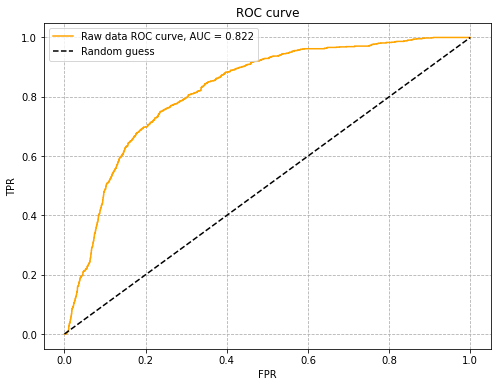

In [17]:
xData = df.drop(["left"], axis=1)
yData = df["left"]

xDataSS = StandardScaler().fit_transform(xData)

score_train, score_test, fpr1, tpr1, auc1 = myLogisticRegression(xDataSS, yData, 0.33, 0)

# plot
plt.figure(figsize=(8, 6))
plt.plot(fpr1, tpr1, linestyle="solid", color="orange", label="Raw data ROC curve, AUC = %.3f" %(auc1))      

plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100), linestyle="dashed", color="black", label="Random guess")

plt.grid(linestyle='--')
plt.title("ROC curve")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.show()

# 結果1

將所有feature原封不動(只對String處理)丟入計算，得到

score of training set = 0.789

score of testing set = 0.791 

AUC = 0.822

### 根據數據之間關係，進行數據處理

Logistic regression = w*x + b 還是一種線性的處理方式，如果資料本身不是線性相關，會導致結果不佳

觀察以下數據與離職率的關係:

1. satisfaction_level     : 對公司的滿意度

2. last_evaluation        : 績效
 
3. number_project         : 參與的專案數目
 
4. average_montly_hours   : 平均月工時
 
5. time_spend_company     : 工作年資 

使用seaborn.histplot(data=your_data, x=check_col, hue=target, bins=100 連續性想切幾格, discrete=True 離散型資料)

In [18]:
# 新建數據後的dataframe
df_re = df.copy()

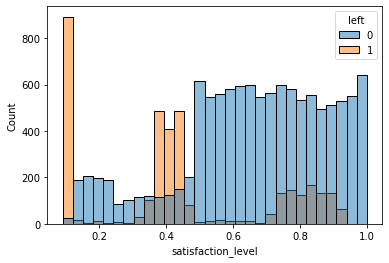

resign ratio: 0.971 at [0.090 ~ 0.120)
resign ratio: 0.078 at [0.120 ~ 0.151)
resign ratio: 0.028 at [0.151 ~ 0.181)
resign ratio: 0.052 at [0.181 ~ 0.211)
resign ratio: 0.031 at [0.211 ~ 0.242)
resign ratio: 0.105 at [0.242 ~ 0.272)
resign ratio: 0.055 at [0.272 ~ 0.302)
resign ratio: 0.192 at [0.302 ~ 0.333)
resign ratio: 0.458 at [0.333 ~ 0.363)
resign ratio: 0.805 at [0.363 ~ 0.393)
resign ratio: 0.763 at [0.393 ~ 0.424)
resign ratio: 0.764 at [0.424 ~ 0.454)
resign ratio: 0.286 at [0.454 ~ 0.484)
resign ratio: 0.016 at [0.484 ~ 0.515)
resign ratio: 0.025 at [0.515 ~ 0.545)
resign ratio: 0.029 at [0.545 ~ 0.575)
resign ratio: 0.024 at [0.575 ~ 0.606)
resign ratio: 0.020 at [0.606 ~ 0.636)
resign ratio: 0.023 at [0.636 ~ 0.666)
resign ratio: 0.004 at [0.666 ~ 0.697)
resign ratio: 0.072 at [0.697 ~ 0.727)
resign ratio: 0.179 at [0.727 ~ 0.757)
resign ratio: 0.201 at [0.757 ~ 0.788)
resign ratio: 0.188 at [0.788 ~ 0.818)
resign ratio: 0.231 at [0.818 ~ 0.848)
resign ratio: 0.213 at [0

In [19]:
# 1. satisfaction_level : 對公司的滿意度

# histogram
g = sns.histplot(data=df, x="satisfaction_level", hue="left")
plt.show()

# recoding resign ratio
listResignRatio = []
listResignRange = []

# get detail in histogram
gpatch = g.patches
#print(len(gpatch))
halfNum = len(gpatch) // 2
binWidth = gpatch[0].get_width()
xList = np.arange(df["satisfaction_level"].min(), df["satisfaction_level"].max(), binWidth)
for idx in range(halfNum):
    resignRatio = gpatch[idx].get_height() / (gpatch[idx].get_height() + gpatch[idx + halfNum].get_height() + 1)
    if (idx == halfNum-1):
        print("resign ratio: %.3f at [%.3f ~ %.3f]" %(resignRatio, xList[idx], xList[idx]+binWidth))
        listResignRatio.append(resignRatio)
        listResignRange.append(xList[idx])
        listResignRange.append(xList[idx]+binWidth)
    else:
        print("resign ratio: %.3f at [%.3f ~ %.3f)" %(resignRatio, xList[idx], xList[idx]+binWidth))
        listResignRatio.append(resignRatio)
        listResignRange.append(xList[idx])
    

滿意度在<0.12, 0.3 ~ 0.48的離職率較高,與 0.72 ~ 0.90 稍高

In [20]:
def projectRatio(x):
    
    ans = 0
    
    for idx in range(0, len(listResignRatio), 1):
        
        if (idx == len(listResignRatio)-1):
            if ((listResignRange[idx] <= x) and (x <= listResignRange[idx+1])):
                ans = listResignRatio[idx]
                break
        else:
            if ((listResignRange[idx] <= x) and (x < listResignRange[idx+1])):
                ans = listResignRatio[idx]
                break

    return ans

df_re["satisfaction_level_re"] = df["satisfaction_level"].apply(projectRatio)

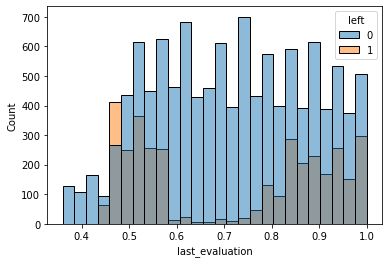

resign ratio: 0.000 at [0.360 ~ 0.385)
resign ratio: 0.000 at [0.385 ~ 0.409)
resign ratio: 0.000 at [0.409 ~ 0.434)
resign ratio: 0.406 at [0.434 ~ 0.458)
resign ratio: 0.607 at [0.458 ~ 0.483)
resign ratio: 0.364 at [0.483 ~ 0.508)
resign ratio: 0.372 at [0.508 ~ 0.532)
resign ratio: 0.364 at [0.532 ~ 0.557)
resign ratio: 0.288 at [0.557 ~ 0.582)
resign ratio: 0.027 at [0.582 ~ 0.606)
resign ratio: 0.031 at [0.606 ~ 0.631)
resign ratio: 0.016 at [0.631 ~ 0.655)
resign ratio: 0.017 at [0.655 ~ 0.680)
resign ratio: 0.029 at [0.680 ~ 0.705)
resign ratio: 0.027 at [0.705 ~ 0.729)
resign ratio: 0.029 at [0.729 ~ 0.754)
resign ratio: 0.098 at [0.754 ~ 0.778)
resign ratio: 0.185 at [0.778 ~ 0.803)
resign ratio: 0.191 at [0.803 ~ 0.828)
resign ratio: 0.327 at [0.828 ~ 0.852)
resign ratio: 0.345 at [0.852 ~ 0.877)
resign ratio: 0.270 at [0.877 ~ 0.902)
resign ratio: 0.303 at [0.902 ~ 0.926)
resign ratio: 0.325 at [0.926 ~ 0.951)
resign ratio: 0.287 at [0.951 ~ 0.975)
resign ratio: 0.369 at [0

In [21]:
# 2. last_evaluation : 績效
        
# histogram
g = sns.histplot(data=df, x="last_evaluation", hue="left")
plt.show()

# recoding resign ratio
listResignRatio = []
listResignRange = []

# get detail in histogram
gpatch = g.patches
#print(len(gpatch))
halfNum = len(gpatch) // 2
binWidth = gpatch[0].get_width()
xList = np.arange(df["last_evaluation"].min(), df["last_evaluation"].max(), binWidth)
for idx in range(halfNum):
    resignRatio = gpatch[idx].get_height() / (gpatch[idx].get_height() + gpatch[idx + halfNum].get_height() + 1)
    if (idx == halfNum-1):
        print("resign ratio: %.3f at [%.3f ~ %.3f]" %(resignRatio, xList[idx], xList[idx]+binWidth))
        listResignRatio.append(resignRatio)
        listResignRange.append(xList[idx])
        listResignRange.append(xList[idx]+binWidth)
    else:
        print("resign ratio: %.3f at [%.3f ~ %.3f)" %(resignRatio, xList[idx], xList[idx]+binWidth))
        listResignRatio.append(resignRatio)
        listResignRange.append(xList[idx])
    

績效0.43~0.58 離職率偏高，0.778後也偏高

In [22]:
def projectRatio(x):
    
    ans = 0
    
    for idx in range(0, len(listResignRatio), 1):
        
        if (idx == len(listResignRatio)-1):
            if ((listResignRange[idx] <= x) and (x <= listResignRange[idx+1])):
                ans = listResignRatio[idx]
                break
        else:
            if ((listResignRange[idx] <= x) and (x < listResignRange[idx+1])):
                ans = listResignRatio[idx]
                break

    return ans

df_re["last_evaluation_re"] = df["last_evaluation"].apply(projectRatio)

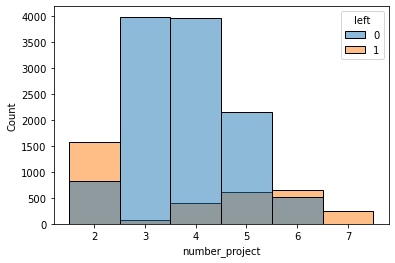

resign ratio: 0.656 at 2
resign ratio: 0.018 at 3
resign ratio: 0.094 at 4
resign ratio: 0.222 at 5
resign ratio: 0.557 at 6
resign ratio: 0.996 at 7


In [23]:
# 3. number_project : 參與的專案數目

g = sns.histplot(data=df, x="number_project", hue="left", discrete=True)
plt.show()

gpatch = g.patches
#print(len(gpatch))
halfNum = len(gpatch) // 2

#texts = [gt.get_text()  for gt in g.axes.get_xticks()]
texts = range(2, 8, 1)

dictResignRatio = dict()

for idx in range(halfNum):
    resignRatio = gpatch[idx].get_height() / (gpatch[idx].get_height() + gpatch[idx + halfNum].get_height() + 1)
    print("resign ratio: %.3f at %s" %(resignRatio, texts[idx]))
    dictResignRatio[texts[idx]] = resignRatio

離散型數據做map or raplace

map: 將對應的數值做轉換，如果有數值沒在規格內，轉成Nan

raplace: 將對應的數值做轉換，如果有數值沒在規格內，則不動

In [24]:
df_re["number_project_re"] = df["number_project"].map(dictResignRatio)

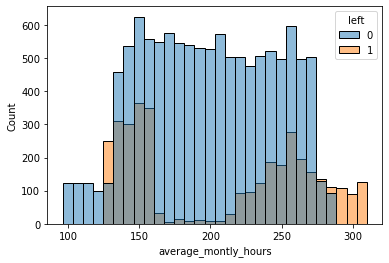

resign ratio: 0.000 at [96.000 ~ 103.133)
resign ratio: 0.000 at [103.133 ~ 110.267)
resign ratio: 0.000 at [110.267 ~ 117.400)
resign ratio: 0.000 at [117.400 ~ 124.533)
resign ratio: 0.668 at [124.533 ~ 131.667)
resign ratio: 0.404 at [131.667 ~ 138.800)
resign ratio: 0.360 at [138.800 ~ 145.933)
resign ratio: 0.368 at [145.933 ~ 153.067)
resign ratio: 0.384 at [153.067 ~ 160.200)
resign ratio: 0.055 at [160.200 ~ 167.333)
resign ratio: 0.010 at [167.333 ~ 174.467)
resign ratio: 0.028 at [174.467 ~ 181.600)
resign ratio: 0.016 at [181.600 ~ 188.733)
resign ratio: 0.020 at [188.733 ~ 195.867)
resign ratio: 0.019 at [195.867 ~ 203.000)
resign ratio: 0.017 at [203.000 ~ 210.133)
resign ratio: 0.055 at [210.133 ~ 217.267)
resign ratio: 0.157 at [217.267 ~ 224.400)
resign ratio: 0.166 at [224.400 ~ 231.533)
resign ratio: 0.195 at [231.533 ~ 238.667)
resign ratio: 0.262 at [238.667 ~ 245.800)
resign ratio: 0.263 at [245.800 ~ 252.933)
resign ratio: 0.317 at [252.933 ~ 260.067)
resign ratio

In [25]:
# 4. average_montly_hours : 平均月工時

# histogram
g = sns.histplot(data=df, x="average_montly_hours", hue="left")
plt.show()

# recoding resign ratio
listResignRatio = []
listResignRange = []

# get detail in histogram
gpatch = g.patches
#print(len(gpatch))
halfNum = len(gpatch) // 2
binWidth = gpatch[0].get_width()
xList = np.arange(df["average_montly_hours"].min(), df["average_montly_hours"].max(), binWidth)
for idx in range(halfNum):
    resignRatio = gpatch[idx].get_height() / (gpatch[idx].get_height() + gpatch[idx + halfNum].get_height() + 1)
    if (idx == halfNum-1):
        print("resign ratio: %.3f at [%.3f ~ %.3f]" %(resignRatio, xList[idx], xList[idx]+binWidth))
        listResignRatio.append(resignRatio)
        listResignRange.append(xList[idx])
        listResignRange.append(xList[idx]+binWidth)
    else:
        print("resign ratio: %.3f at [%.3f ~ %.3f)" %(resignRatio, xList[idx], xList[idx]+binWidth))
        listResignRatio.append(resignRatio)
        listResignRange.append(xList[idx])

In [26]:
def projectRatio(x):
    
    ans = 0
    
    for idx in range(0, len(listResignRatio), 1):
        
        if (idx == len(listResignRatio)-1):
            if ((listResignRange[idx] <= x) and (x <= listResignRange[idx+1])):
                ans = listResignRatio[idx]
                break
        else:
            if ((listResignRange[idx] <= x) and (x < listResignRange[idx+1])):
                ans = listResignRatio[idx]
                break

    return ans

df_re["average_montly_hours_re"] = df["average_montly_hours"].apply(projectRatio)

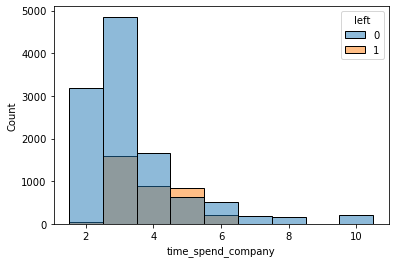

resign ratio: 0.016 at 2
resign ratio: 0.246 at 3
resign ratio: 0.348 at 4
resign ratio: 0.565 at 5
resign ratio: 0.291 at 6
resign ratio: 0.000 at 7
resign ratio: 0.000 at 8
resign ratio: 0.000 at 9
resign ratio: 0.000 at 10


In [27]:
# 5. time_spend_company : 工作年資

g = sns.histplot(data=df, x="time_spend_company", hue="left", discrete=True)
plt.show()

gpatch = g.patches
#print(len(gpatch))
halfNum = len(gpatch) // 2

#texts = [gt.get_text()  for gt in g.axes.get_xticks()]
texts = range(2, 11, 1)

dictResignRatio = dict()

for idx in range(halfNum):
    resignRatio = gpatch[idx].get_height() / (gpatch[idx].get_height() + gpatch[idx + halfNum].get_height() + 1)
    print("resign ratio: %.3f at %s" %(resignRatio, texts[idx]))
    dictResignRatio[texts[idx]] = resignRatio

In [28]:
df_re["time_spend_company_re"] = df["time_spend_company"].map(dictResignRatio)

In [29]:
# drop non-linear data
df_re2 = df_re.copy()
df_re = df_re.drop(["satisfaction_level", "last_evaluation", "number_project", "average_montly_hours", "average_montly_hours", "time_spend_company"], axis=1)
df_re


,Work_accident,left,promotion_last_5years,sales_IT,sales_RandD,sales_accounting,sales_hr,sales_management,sales_marketing,sales_product_mng,...,sales_support,sales_technical,salary_high,salary_low,salary_medium,satisfaction_level_re,last_evaluation_re,number_project_re,average_montly_hours_re,time_spend_company_re
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0.805281,0.371808,0.655923,0.383682,0.246120
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0.187879,0.345000,0.221579,0.283862,0.290682
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0.970620,0.269822,0.996109,0.236006,0.347928
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0.072488,0.345000,0.221579,0.156928,0.565129
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0.805281,0.371808,0.655923,0.383682,0.246120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14994,0,1,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0.763060,0.288309,0.655923,0.368049,0.246120
14995,0,1,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0.805281,0.607090,0.655923,0.383682,0.246120
14996,0,1,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0.805281,0.371808,0.655923,0.359524,0.246120
14997,0,1,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0.970620,0.287072,0.557447,0.511364,0.347928


## 將非線性的數據，投影至離職率空間

Score of training set = 0.933
Score of testing set = 0.937 
AUC = 0.968 
Report: 
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      3818
           1       0.89      0.83      0.86      1132

    accuracy                           0.94      4950
   macro avg       0.92      0.90      0.91      4950
weighted avg       0.94      0.94      0.94      4950



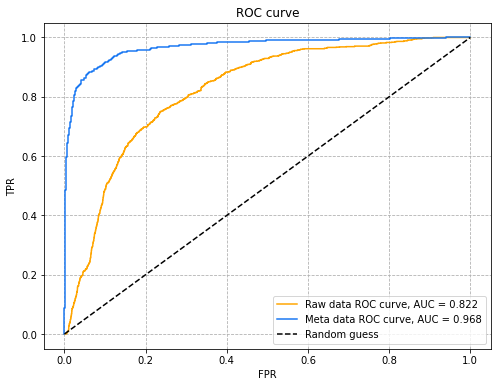

In [30]:
# after pre-processing data

xData = df_re.drop(["left"], axis=1)
yData = df_re["left"]

xDataSS = StandardScaler().fit_transform(xData)

score_train, score_test, fpr2, tpr2, auc2 = myLogisticRegression(xDataSS, yData, 0.33, 0)

# plot
plt.figure(figsize=(8, 6))
plt.plot(fpr1, tpr1, linestyle="solid", color="orange", label="Raw data ROC curve, AUC = %.3f" %(auc1))    
plt.plot(fpr2, tpr2, linestyle="solid", color="#1877F2", label="Meta data ROC curve, AUC = %.3f" %(auc2))    

plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100), linestyle="dashed", color="black", label="Random guess")

plt.grid(linestyle='--')
plt.title("ROC curve")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.show()

Score of training set = 0.943
Score of testing set = 0.943 
AUC = 0.971 
Report: 
              precision    recall  f1-score   support

           0       0.96      0.97      0.96      3818
           1       0.89      0.85      0.87      1132

    accuracy                           0.94      4950
   macro avg       0.93      0.91      0.92      4950
weighted avg       0.94      0.94      0.94      4950



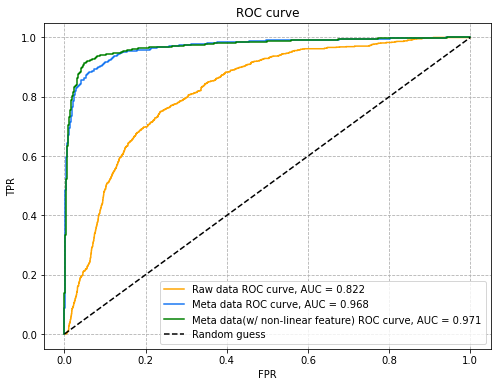

In [31]:
# after pre-processing data

xData = df_re2.drop(["left"], axis=1)
yData = df_re2["left"]

xDataSS = StandardScaler().fit_transform(xData)

score_train, score_test, fpr3, tpr3, auc3 = myLogisticRegression(xDataSS, yData, 0.33, 0)

# plot
plt.figure(figsize=(8, 6))
plt.plot(fpr1, tpr1, linestyle="solid", color="orange", label="Raw data ROC curve, AUC = %.3f" %(auc1))    
plt.plot(fpr2, tpr2, linestyle="solid", color="#1877F2", label="Meta data ROC curve, AUC = %.3f" %(auc2))   
plt.plot(fpr3, tpr3, linestyle="solid", color="green", label="Meta data(w/ non-linear feature) ROC curve, AUC = %.3f" %(auc3))   
plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100), linestyle="dashed", color="black", label="Random guess")

plt.grid(linestyle='--')
plt.title("ROC curve")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.show()

In [32]:
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import f_regression

# Modelization
def StrategyCompare(X, Y):
    
    fpr = dict()
    tpr = dict()
    auc = np.zeros(5)
    
    # get Y name
    target = Y.name
    
    # check data is unique, if not => std = 0, then divid 0 will error
    def is_unique(s):
        a = s.to_numpy() # s.values (pandas<0.24)
        return (a[0] == a).all()
    
    # remove the same data
    for idx in X.columns:
        if (is_unique(X[idx])):
            print("drop data at", idx)
            X = X.drop([idx], axis=1)
    
    index_list = ["All", "pos-corr_top3", "neg-corr_top3", "F-test_top3", "MI_top3"]
    col_list = ["Score_train", "Score_test", "AUC", "Feature"]
    res = pd.DataFrame(columns=col_list, index=index_list)
    
    # ================== All ==================
    print("\n=== All feature ===") 
    
    score_train, score_test, fpr[0], tpr[0], auc[0]  = myLogisticRegression(X, Y, 0.33, 0)
    res.loc["All"]["Score_train"] = score_train
    res.loc["All"]["Score_test"] = score_test
    res.loc["All"]["AUC"] = auc[0]
    res.loc["All"]["Feature"] = "All"
    
    
    
    # ================== correlation matrix ==================
    df_corr = X.copy()
    df_corr[target] = Y.copy()
    correlation_matrix = df_corr.corr().round(2) # 取到第2位
    corr_sort = correlation_matrix[target].sort_values(ascending=False) #
    corr_sort = corr_sort.drop([target], axis=0) # remove target data
    corr_sort = corr_sort.fillna(0) # fill nan data with 0
    
    # positive-correlation top3
    print("\n=== positive-correlation top3 feature ===")
    
    feature_list = corr_sort.head(3).index
    
    X_strategy = pd.concat([X[idx] for idx in feature_list], axis=1)
    score_train, score_test, fpr[1], tpr[1], auc[1] = myLogisticRegression(X_strategy, Y, 0.33, 0)
    res.loc["pos-corr_top3"]["Score_train"] = score_train
    res.loc["pos-corr_top3"]["Score_test"] = score_test
    res.loc["pos-corr_top3"]["AUC"] = auc[1]
    res.loc["pos-corr_top3"]["Feature"] = feature_list.values
    
    # negative-correlation top3
    print("\n=== negative-correlation top3 feature ===")
    
    feature_list = corr_sort.tail(3).index
    X_strategy = pd.concat([X[idx] for idx in feature_list], axis=1)
    score_train, score_test, fpr[2], tpr[2], auc[2] = myLogisticRegression(X_strategy, Y, 0.33, 0)
    res.loc["neg-corr_top3"]["Score_train"] = score_train
    res.loc["neg-corr_top3"]["Score_test"] = score_test
    res.loc["neg-corr_top3"]["AUC"] = auc[2]
    res.loc["neg-corr_top3"]["Feature"] = feature_list.values
    
    
    
    # ================== F-test ==================
    print("\n=== F-test top3 feature ===")

    f, p = f_regression(X, Y)
    df_ftest = pd.DataFrame({"f-stat":f, "p-val":p}, index=X.columns)
    df_ftest = df_ftest.sort_values(by=["f-stat"], ascending=False)
    feature_list = df_ftest.head(3).index[:]

    X_strategy = pd.concat([X[idx] for idx in feature_list], axis=1)
    score_train, score_test, fpr[3], tpr[3], auc[3] = myLogisticRegression(X_strategy, Y, 0.33, 0)
    res.loc["F-test_top3"]["Score_train"] = score_train
    res.loc["F-test_top3"]["Score_test"] = score_test
    res.loc["F-test_top3"]["AUC"] = auc[3]
    res.loc["F-test_top3"]["Feature"] = feature_list.values
    
    
    
    # ================== Mutual info ==================
    print("\n=== Mutual info top3 feature ===")
    
    mi = mutual_info_regression(X, Y)
    df_mi = pd.DataFrame({"MI":mi}, index=X.columns)
    df_mi = df_mi.sort_values(by=["MI"], ascending=False)
    feature_list = df_mi.head(3).index[:]
    
    X_strategy = pd.concat([df_corr[idx] for idx in feature_list], axis=1)
    score_train, score_test, fpr[4], tpr[4], auc[4] = myLogisticRegression(X_strategy, Y, 0.33, 0)
    res.loc["MI_top3"]["Score_train"] = score_train
    res.loc["MI_top3"]["Score_test"] = score_test
    res.loc["MI_top3"]["AUC"] = auc[4]
    res.loc["MI_top3"]["Feature"] = feature_list.values

    
    # plot
    plt.figure(figsize=(8, 6))
    cmap = ["red", "green", "blue", "orange", "aqua"]
    for idx in range(5):
        plt.plot(fpr[idx], tpr[idx], linestyle="solid", color=cmap[idx], label="ROC curve w/ %s feature, AUC = %.3f" %(index_list[idx], auc[idx]))   
    
    plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100), linestyle="dashed", color="black", label="Random guess")
    plt.grid(linestyle='--')
    plt.title("ROC curve")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.legend()
    plt.show()
    
    return res




=== All feature ===
Score of training set = 0.943
Score of testing set = 0.943 
AUC = 0.971 
Report: 
              precision    recall  f1-score   support

           0       0.96      0.97      0.96      3818
           1       0.89      0.85      0.87      1132

    accuracy                           0.94      4950
   macro avg       0.93      0.91      0.92      4950
weighted avg       0.94      0.94      0.94      4950


=== positive-correlation top3 feature ===
Score of training set = 0.901
Score of testing set = 0.908 
AUC = 0.917 
Report: 
              precision    recall  f1-score   support

           0       0.91      0.97      0.94      3818
           1       0.89      0.69      0.77      1132

    accuracy                           0.91      4950
   macro avg       0.90      0.83      0.86      4950
weighted avg       0.91      0.91      0.90      4950


=== negative-correlation top3 feature ===
Score of training set = 0.768
Score of testing set = 0.776 
AUC = 0.785 
Re

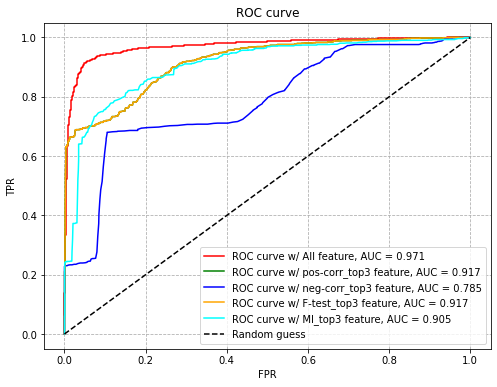

,Score_train,Score_test,AUC,Feature
All,0.943477,0.943232,0.971119,All
pos-corr_top3,0.900985,0.908081,0.91677,"[satisfaction_level_re, number_project_re, ave..."
neg-corr_top3,0.767639,0.776162,0.78484,"[salary_high, Work_accident, satisfaction_level]"
F-test_top3,0.900985,0.908081,0.91677,"[satisfaction_level_re, number_project_re, ave..."
MI_top3,0.882078,0.890303,0.905263,"[satisfaction_level, satisfaction_level_re, nu..."


In [33]:
xData = df_re2.drop(["left"], axis=1)
yData = df_re2["left"]

xDataSS = StandardScaler().fit_transform(xData)
xDataSS = pd.DataFrame(xDataSS, columns=xData.columns)

StrategyCompare(xDataSS, yData)

### Other feature

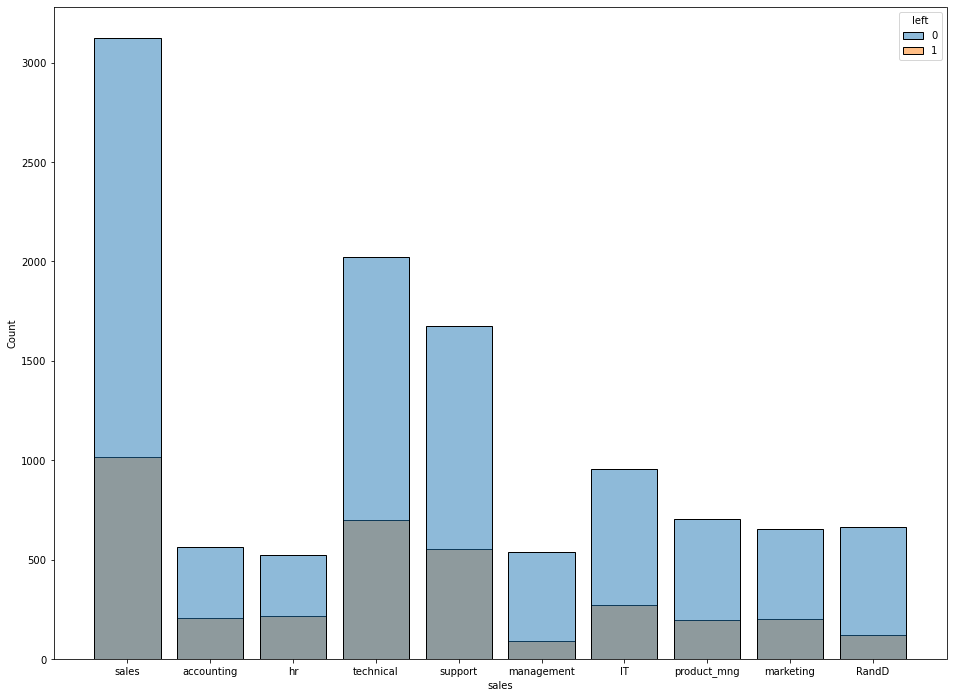

resign ratio: 0.245 at sales
resign ratio: 0.266 at accounting
resign ratio: 0.291 at hr
resign ratio: 0.256 at technical
resign ratio: 0.249 at support
resign ratio: 0.144 at management
resign ratio: 0.222 at IT
resign ratio: 0.219 at product_mng
resign ratio: 0.236 at marketing
resign ratio: 0.154 at RandD


In [34]:
# sales

plt.figure(figsize=(16, 12))

g = sns.histplot(data=rawData, x="sales", hue="left", shrink=0.8)
plt.show()

gpatch = g.patches
#print(len(gpatch))
halfNum = len(gpatch) // 2

texts = [gt.get_text()  for gt in g.axes.get_xticklabels()]

#print(texts)

for idx in range(halfNum):
    resignRatio = gpatch[idx].get_height() / (gpatch[idx].get_height() + gpatch[idx + halfNum].get_height() + 1)
    print("resign ratio: %.3f at %s" %(resignRatio, texts[idx]))